In [18]:
import os 
import pandas as pd
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from keras.utils.vis_utils import plot_model
import cv2

from tensorflow.keras import backend as K

In [2]:
def generate_dataset_from_directory(folder_path, size = 224,batch_size = 32): 
    image_generator = ImageDataGenerator(
        samplewise_center=True, #Set each sample mean to 0.
        samplewise_std_normalization= True, # Divide each input by its standard deviation]
        #rescale=1./255,
        validation_split = 0.3
    )

    #create training and testing datasets
    train_data = image_generator.flow_from_directory(directory = 
        folder_path,
        class_mode="categorical",
        color_mode="rgb",
        target_size = (size, size),
        batch_size  = batch_size,
        shuffle=True,
        seed=123,
        subset="training"
    )

    #create training and testing datasets
    val_data = image_generator.flow_from_directory(directory = 
        folder_path,
        class_mode="categorical",
        color_mode="rgb",
        target_size = (size, size),
        batch_size  = batch_size,
        shuffle=True,
        seed=123,
        subset="validation"
    )

    return train_data, val_data

In [3]:
folder_path = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/'
train_data, val_data = generate_dataset_from_directory(
    folder_path, size = 128,batch_size = 32)

Found 14818 images belonging to 4 classes.
Found 6347 images belonging to 4 classes.


In [4]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig, ax = plt.subplots(1,2,figsize=(20,10))
  ax[0].plot(epochRange,history.history['accuracy'],'b',label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],'r',label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch', fontsize = 20)
  ax[0].set_ylabel('Accuracy', fontsize = 20)
  ax[0].legend()
  ax[0].grid(color='gray', linestyle='--')
  ax[1].plot(epochRange,history.history['loss'],'b',label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],'r',label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch', fontsize = 20)
  ax[1].set_ylabel('Loss', fontsize = 20)
  ax[1].legend()
  ax[1].grid(color='gray', linestyle='--')
  plt.show()

In [9]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [10]:
def resnet_model(train_data,test_data, epochs,size):
#Building the model using Keras functional API
    print("----Building the model----")
    
    base_model = ResNet50(input_shape= (size,size,3), include_top=False)
#     base_model.trainable=False #freezing the layer


    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    out=Dense(4,activation='softmax')(x)

    model=Model(inputs=base_model.input,outputs=out) 
    # model.summary()
#Training the Convolutional Neural Network
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy',f1_m,precision_m, recall_m])
    
    early_stop = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               patience = 5 ,
                               restore_best_weights=True)
    #model_checkpoint
    mc = ModelCheckpoint('resnet_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    r = model.fit(train_data, 
                  validation_data = val_data, 
                  epochs = epochs, 
                  verbose = 1,
                  batch_size = 32,
                  callbacks = [early_stop,mc])
    print("Train score:", model.evaluate(train_data))
    print("Test score:", model.evaluate(val_data))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 

In [11]:
epochs = 3
r,model,n_epochs = resnet_model(train_data, val_data,epochs,128)

----Building the model----
----Training the network----
Epoch 1/3


2022-01-20 15:59:53.639440: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


464/464 [==============================] - 187s 380ms/step - loss: 0.3317 - accuracy: 0.8807 - f1_m: 0.8738 - precision_m: 0.8940 - recall_m: 0.8581 - val_loss: 1.6608 - val_accuracy: 0.2875 - val_f1_m: 0.2455 - val_precision_m: 0.2770 - val_recall_m: 0.2211

Epoch 00001: val_loss improved from inf to 1.66075, saving model to resnet_model.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/3
464/464 [==============================] - 78s 167ms/step - loss: 0.1559 - accuracy: 0.9436 - f1_m: 0.9439 - precision_m: 0.9461 - recall_m: 0.9418 - val_loss: 0.3227 - val_accuracy: 0.8984 - val_f1_m: 0.8976 - val_precision_m: 0.9013 - val_recall_m: 0.8940

Epoch 00002: val_loss improved from 1.66075 to 0.32271, saving model to resnet_model.h5
Epoch 3/3
464/464 [==============================] - 78s 168ms/step - loss: 0.1121 - accuracy: 0.9602 - f1_m: 0.9594 - precision_m: 0.9603 - recall_m: 0.9585 - val_loss: 0.2286 - val_accuracy: 0.9289 - val_f1_m: 0.9290 - val_precision_m: 0.9303 - val_recall_m: 0.9278

Epoch 00003: val_loss improved from 0.32271 to 0.22859, saving model to resnet_model.h5
464/464 [==============================] - 50s 107ms/step - loss: 0.0702 - accuracy: 0.9746 - f1_m: 0.9748 - precision_m: 0.9752 - recall_m: 0.9744
Train score: [0.07017667591571808, 0.9746254682540894, 0.97479647397995, 0.9751981496810913, 0.9744073152542114]
199/199 [================

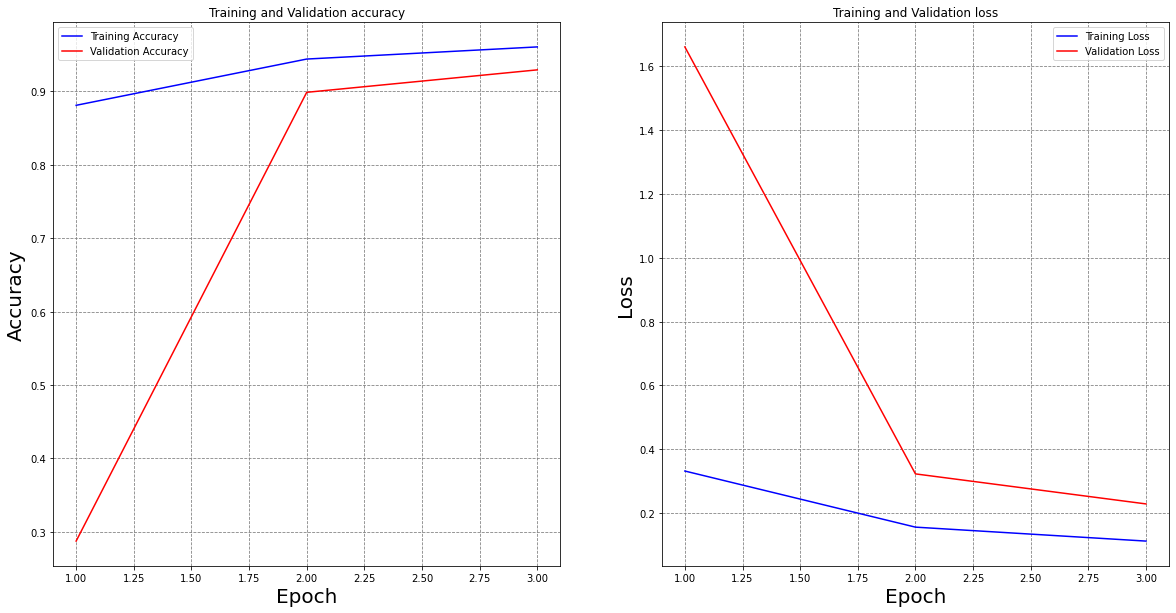

In [12]:
plotLearningCurve(r,n_epochs)

In [13]:
test_evaluation = model.evaluate(val_data)
print(f"Test Accuracy using ResNet50: {test_evaluation[1] * 100:.2f}%")

train_evaluation = model.evaluate(train_data)
print(f"Train Accuracy using ResNet50: {train_evaluation[1] * 100:.2f}%")

199/199 [==============================] - 21s 107ms/step - loss: 0.2286 - accuracy: 0.9289 - f1_m: 0.9293 - precision_m: 0.9306 - recall_m: 0.9281
Test Accuracy using ResNet50: 92.89%
464/464 [==============================] - 53s 113ms/step - loss: 0.0702 - accuracy: 0.9746 - f1_m: 0.9748 - precision_m: 0.9752 - recall_m: 0.9744
Train Accuracy using ResNet50: 97.46%


In [14]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

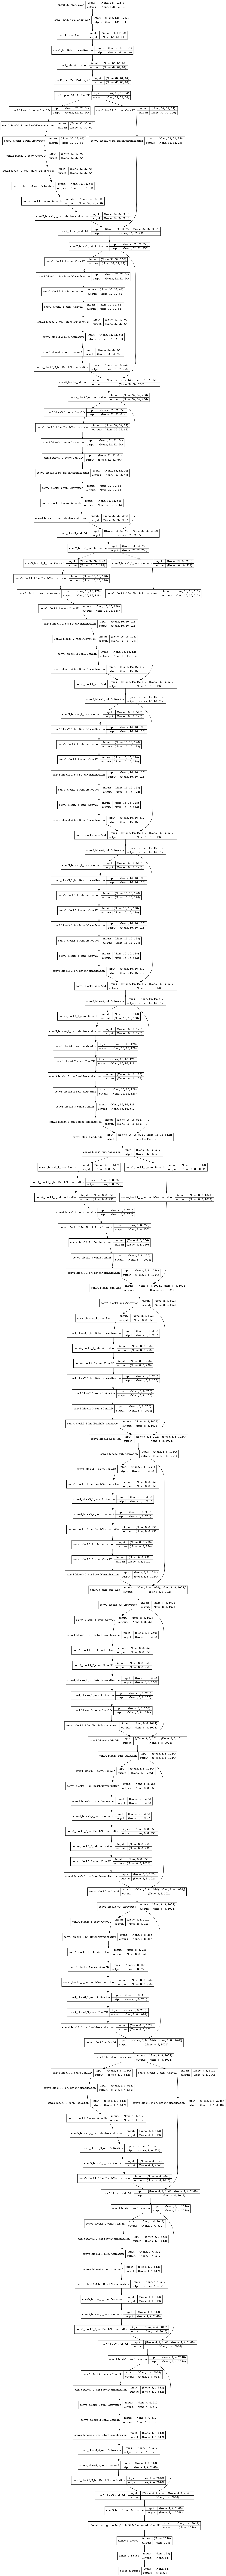

In [19]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)